# Global optimization

## (a) Optuna: hyperparameters for random forest on Iris.
In this task you will use [optuna](https://optuna.org/) package for 
hyperparameter optimization in credit card Fraud detection dataset. Examples can be find [here](https://optuna.org/#code_examples) or [here](https://www.kaggle.com/dixhom/bayesian-optimization-with-optuna-stacking/)

This [example](https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/structured_data/ipynb/imbalanced_classification.ipynb#scrollTo=yxK_u7msJeI6) looks at the [Kaggle Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud/) dataset to demonstrate how to train a classification model on data with highly imbalanced classes.

In [1]:
!pip install optuna
!pip install keras

     |████████████████████████████████| 308 kB 8.5 MB/s 
     |████████████████████████████████| 80 kB 4.9 MB/s 
     |████████████████████████████████| 209 kB 51.5 MB/s 
     |████████████████████████████████| 75 kB 2.7 MB/s 
     |████████████████████████████████| 111 kB 51.8 MB/s 
     |████████████████████████████████| 49 kB 3.4 MB/s 
     |████████████████████████████████| 144 kB 30.0 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=173f1b0c23480ab858f3451a7c4bd66fc227408c27be539101a01f1e52ff5f4a
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [2]:
# Getting dataset with credit card data
!wget -O creditcard.csv.zip "https://github.com/MerkulovDaniil/sber21_fmin/raw/sources/data/creditcard.csv.zip"
!unzip creditcard.csv.zip

--2021-10-10 16:56:10--  https://github.com/MerkulovDaniil/sber21_fmin/raw/sources/data/creditcard.csv.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MerkulovDaniil/sber21_fmin/sources/data/creditcard.csv.zip [following]
--2021-10-10 16:56:10--  https://raw.githubusercontent.com/MerkulovDaniil/sber21_fmin/sources/data/creditcard.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69155672 (66M) [application/zip]
Saving to: ‘creditcard.csv.zip’

creditcard.csv.zip  100%[===================>]  65.95M   203MB/s    in 0.3s    

2021-10-10 16:56:12 (203 MB/s) - ‘creditcard.csv.zip’ saved

## First, vectorize the CSV data

In [3]:
import csv
import numpy as np

# Get the real data from https://www.kaggle.com/mlg-ulb/creditcardfraud/

fname = "creditcard.csv"

all_features = []
all_targets = []
with open(fname) as f:
    for i, line in enumerate(f):
        if i == 0:
            print("HEADER:", line.strip())
            continue  # Skip header
        fields = line.strip().split(",")
        all_features.append([float(v.replace('"', "")) for v in fields[:-1]])
        all_targets.append([int(fields[-1].replace('"', ""))])
        if i == 1:
            print("EXAMPLE FEATURES:", all_features[-1])

features = np.array(all_features, dtype="float32")
targets = np.array(all_targets, dtype="uint8")
print("features.shape:", features.shape)
print("targets.shape:", targets.shape)


HEADER: "Time","V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20","V21","V22","V23","V24","V25","V26","V27","V28","Amount","Class"
EXAMPLE FEATURES: [0.0, -1.3598071336738, -0.0727811733098497, 2.53634673796914, 1.37815522427443, -0.338320769942518, 0.462387777762292, 0.239598554061257, 0.0986979012610507, 0.363786969611213, 0.0907941719789316, -0.551599533260813, -0.617800855762348, -0.991389847235408, -0.311169353699879, 1.46817697209427, -0.470400525259478, 0.207971241929242, 0.0257905801985591, 0.403992960255733, 0.251412098239705, -0.018306777944153, 0.277837575558899, -0.110473910188767, 0.0669280749146731, 0.128539358273528, -0.189114843888824, 0.133558376740387, -0.0210530534538215, 149.62]
features.shape: (284807, 30)
targets.shape: (284807, 1)


## Prepare a validation set

In [4]:
num_val_samples = int(len(features) * 0.2)
train_features = features[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_features = features[-num_val_samples:]
val_targets = targets[-num_val_samples:]

print("Number of training samples:", len(train_features))
print("Number of validation samples:", len(val_features))


Number of training samples: 227846
Number of validation samples: 56961


## Analyze class imbalance in the targets

In [5]:
counts = np.bincount(train_targets[:, 0])
print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(train_targets)
    )
)

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]


Number of positive samples in training data: 417 (0.18% of total)


## Normalize the data using training set statistics

In [6]:
mean = np.mean(train_features, axis=0)
train_features -= mean
val_features -= mean
std = np.std(train_features, axis=0)
train_features /= std
val_features /= std


## Build a binary classification model

In [7]:
from tensorflow import keras

model = keras.Sequential(
    [
        keras.layers.Dense(
            256, activation="relu", input_shape=(train_features.shape[-1],)
        ),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               7936      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 139,777
Trainable params: 139,777
Non-trainable params: 0
__________________________________________________

## Train the model with `class_weight` argument

In [8]:
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy", metrics=metrics
)

callbacks = [keras.callbacks.ModelCheckpoint("fraud_model_at_epoch_{epoch}.h5")]
class_weight = {0: weight_for_0, 1: weight_for_1}

model.fit(
    train_features,
    train_targets,
    batch_size=2048,
    epochs=30,
    verbose=2,
    callbacks=callbacks,
    validation_data=(val_features, val_targets),
    class_weight=class_weight,
)


Epoch 1/30
112/112 - 8s - loss: 2.2419e-06 - fn: 45.0000 - fp: 25877.0000 - tn: 201552.0000 - tp: 372.0000 - precision: 0.0142 - recall: 0.8921 - val_loss: 0.0932 - val_fn: 7.0000 - val_fp: 1338.0000 - val_tn: 55548.0000 - val_tp: 68.0000 - val_precision: 0.0484 - val_recall: 0.9067
Epoch 2/30
112/112 - 6s - loss: 1.4183e-06 - fn: 39.0000 - fp: 7477.0000 - tn: 219952.0000 - tp: 378.0000 - precision: 0.0481 - recall: 0.9065 - val_loss: 0.0533 - val_fn: 10.0000 - val_fp: 524.0000 - val_tn: 56362.0000 - val_tp: 65.0000 - val_precision: 0.1104 - val_recall: 0.8667
Epoch 3/30
112/112 - 6s - loss: 1.2303e-06 - fn: 33.0000 - fp: 6367.0000 - tn: 221062.0000 - tp: 384.0000 - precision: 0.0569 - recall: 0.9209 - val_loss: 0.0977 - val_fn: 7.0000 - val_fp: 2022.0000 - val_tn: 54864.0000 - val_tp: 68.0000 - val_precision: 0.0325 - val_recall: 0.9067
Epoch 4/30
112/112 - 6s - loss: 1.0311e-06 - fn: 21.0000 - fp: 6700.0000 - tn: 220729.0000 - tp: 396.0000 - precision: 0.0558 - recall: 0.9496 - val_l

## Conclusions

At the end of training, out of 56,961 validation transactions, we are:

- Correctly identifying 66 of them as fraudulent
- Missing 9 fraudulent transactions
- At the cost of incorrectly flagging 441 legitimate transactions

In the real world, one would put an even higher weight on class 1,
so as to reflect that False Negatives are more costly than False Positives.

Next time your credit card gets  declined in an online purchase -- this is why.

## Try to tune any set of hyperparameters in the problem above with optuna library. Possible variants

* weights of the classes
* number of layers in the neural network
* learning rate and batch size

Also you are able t choose any metric you want.

## (b) EXTRA
Implement Rastrigin function $f: \mathbb{R}^d \to \mathbb{R}$ for d = 10. [link](https://www.sfu.ca/~ssurjano/rastr.html)

$$
f(\mathbf{x})=10 d+\sum_{i=1}^{d}\left[x_{i}^{2}-10 \cos \left(2 \pi x_{i}\right)\right]
$$

In [ ]:
def rast():
    pass

* Consider scipy global optimization from [here](https://docs.scipy.org/doc/scipy/reference/optimize.html#global-optimization).
* Plot 4 graphs for different $d$ from {2, 4, 6, 8}. On each graph you are to plot $f$ from $N_{fev}$ for 4 methods: `basinhopping`, `differential_evolution`, `shgo`, `dual_annealing` from scipy, where $N_{fev}$ - the number of function evaluations. This information is usually avalable from `specific_optimizer.nfev`. If you will need bounds for the optimizer, use $x_i \in [-5, 5]$.
* Please, try to use `brute` method also. Explain the results🤔

Text(0.5, 0.98, 'EXAMPLE')

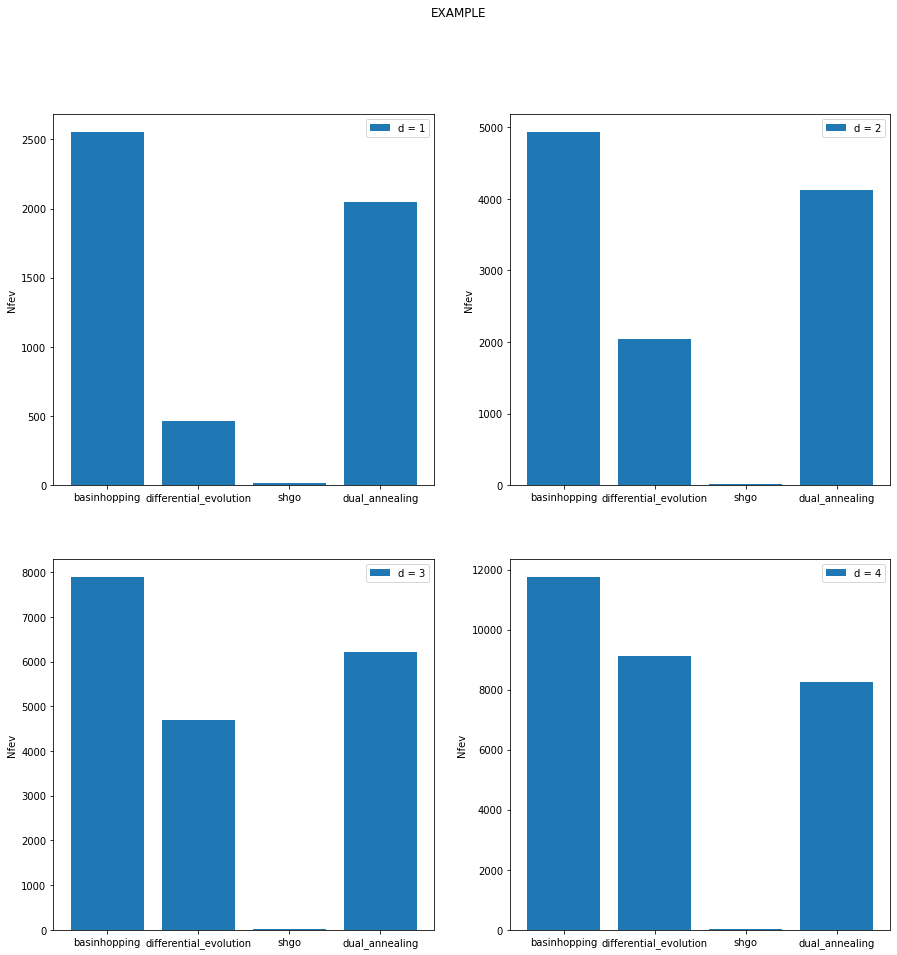

# Materials

* [ZOOpt](https://github.com/eyounx/ZOOpt) A python package of Zeroth-Order Optimization
* [Nevergrad](https://github.com/facebookresearch/nevergrad) A Python toolbox for performing gradient-free optimization
* [Optuna](https://colab.research.google.com/github/optuna/optuna/blob/master/examples/quickstart.ipynb) tutorial.